# Amazon

This notebook is an example on how to use the VerticaPy Library. We will use the Amazon dataset to predict the number of forest fires in Brazil. You can download the Jupyter Notebook of the study by clicking <a href="amazon.ipynb">here</a>. To achieve our goals, we have access to the following data. 
<ul>
    <li><b>date: </b>Date of the record</li>
    <li><b>number: </b>Number of forest fires</li>
    <li><b>state: </b>State in Brazil</li>
</ul>
We will follow the entire Data Science cycle (Data Exploration - Data Preparation - Data Modeling - Model Evaluation - Model Deployment) and solve this easy use-case. The purpose is to show you some of the library interesting functionalities.

## Initialization

Let's create a Virtual DataFrame of the dataset.

In [1]:
from verticapy.learn.datasets import load_amazon
amazon = load_amazon()
amazon.head(5)

<object>  Name: amazon, Number of rows: 6454, Number of columns: 3

## Data Exploration and Preparation

Let's explore the data by displaying descriptive statistics of all the columns.

In [2]:
amazon.describe(method = "categorical")

<object>

Data are available from 1998 to the end of 2017.

In [3]:
amazon["date"].describe()

<object>

The number of forest fires should be seasonal as Brazil is facing two seasons: the dried season and the raining season. Let's confirm the hypothesis using an autocorrelation plot with 48 lags (4 years).

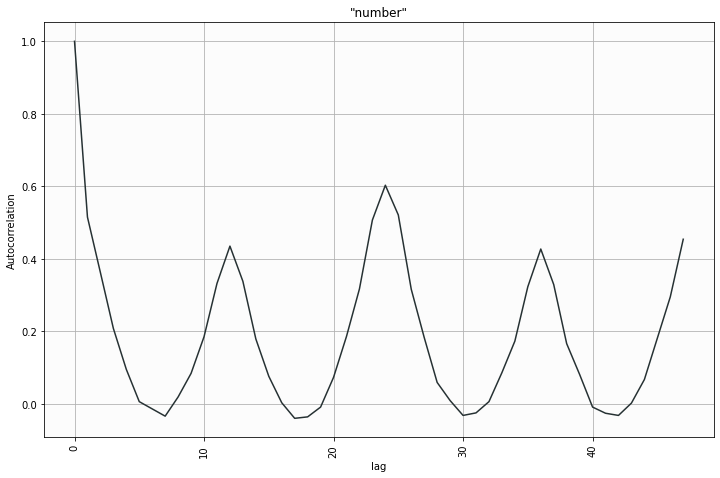

In [4]:
%matplotlib inline
x = amazon.autocorr(column = "number", 
                    ts = "date",
                    by = ["state"],
                    p = 48)

The process seems to be stationary. Let's use a Dickey Fuller test to confirm our hypothesis.

In [5]:
amazon.testdf(ts = "date", column = "number", p = 12)

We test the following hypothesis:
(H0) The time series "number" = f("date") is non-stationary
(H1) The time series "number" = f("date") is stationary
👍 - The Process might be stationary (time independent structure)
gamma + 1 = 0.595566558738601
p_value = 8.7091028987442E-214


(True, 0.595566558738601, 8.7091028987442e-214)

The seasonality is clearly visible. Let's see it graphically using the cumulative sum of the number of forest fires partitioned by states. If it is the case, it will plot staircase functions.

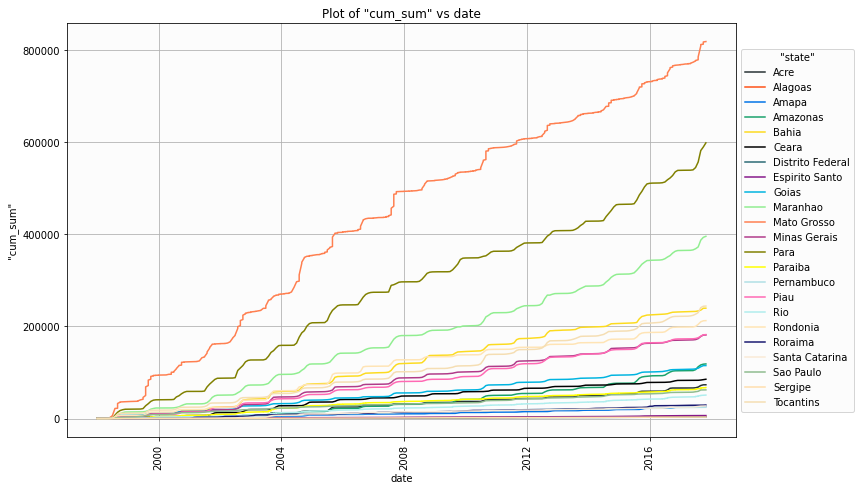

In [6]:
amazon.cumsum("number", by = ["state"], order_by = ["date"], name = "cum_sum")
x = amazon["cum_sum"].plot(ts = "date", by = "state")

We can clearly see the seasonality per state which lead to a global seasonality. Let's draw the cumulative sum to see more clearly the phenomenon.

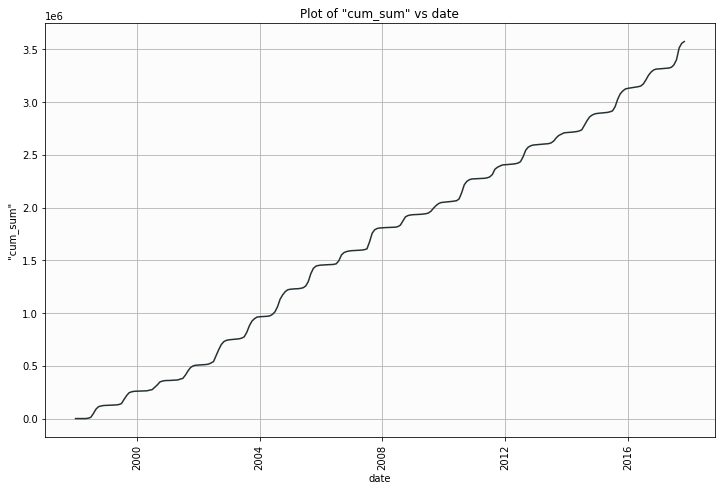

In [7]:
amazon = amazon.groupby(["date"], ["SUM(number) AS number"])
amazon.cumsum("number", order_by = ["date"], name = "cum_sum")
x = amazon["cum_sum"].plot(ts = "date")

Let's create a Linear Regression model to predict the number of forest fires in Brazil. We saw the TS seasonality, so let's create the lags of the response.

In [8]:
amazon = load_amazon()
for i in range(1,25):
    amazon.analytic(func = "lag", 
                    column = "number", 
                    by = ["state"], 
                    order_by = ["date"],
                    name = "lag_number_{}".format(i),
                    offset = i)

Let's save the view in the Vertica DB to create our linear regression model.

In [9]:
from verticapy.utilities import drop_view
drop_view("amazon_clean")
amazon.to_db("amazon_clean")

The view amazon_clean was successfully dropped.


<object>  Name: amazon, Number of rows: 6454, Number of columns: 27

## Machine Learning

Let's create a Linear Regression model to predict the number of forest fires in Brazil.

In [10]:
from verticapy.learn.linear_model import LinearRegression
from verticapy.learn.model_selection import cross_validate
from verticapy.utilities import drop_model

predictors = ["lag_number_{}".format(i) for i in range(1,25)]
response = "number"
relation = "amazon_clean"
drop_model("amazon_lr")
model = LinearRegression("amazon_lr")
cross_validate(model, relation, predictors, response)

The model amazon_lr was successfully dropped.


<object>

The model is excellent as expected. Let's create the final model using the entire dataset.

In [11]:
model.fit(relation, predictors, response)



details
  predictor  |coefficient|std_err |t_value |p_value 
-------------+-----------+--------+--------+--------
  Intercept  | 50.35234  |18.86882| 2.66855| 0.00764
lag_number_1 |  0.18469  | 0.01262|14.63234| 0.00000
lag_number_2 |  0.12338  | 0.01262| 9.77702| 0.00000
lag_number_3 |  0.02746  | 0.01313| 2.09069| 0.03660
lag_number_4 |  0.02752  | 0.01317| 2.08909| 0.03674
lag_number_5 | -0.01374  | 0.01320|-1.04113| 0.29786
lag_number_6 |  0.02439  | 0.01361| 1.79198| 0.07319
lag_number_7 | -0.02833  | 0.01354|-2.09192| 0.03649
lag_number_8 |  0.00534  | 0.01354| 0.39405| 0.69356
lag_number_9 | -0.02780  | 0.01352|-2.05608| 0.03982
lag_number_10| -0.05342  | 0.01332|-4.00916| 0.00006
lag_number_11|  0.04054  | 0.01328| 3.05271| 0.00228
lag_number_12|  0.18040  | 0.01327|13.59807| 0.00000
lag_number_13|  0.06327  | 0.01325| 4.77373| 0.00000
lag_number_14| -0.07443  | 0.01327|-5.60980| 0.00000
lag_number_15| -0.05221  | 0.01331|-3.92338| 0.00009
lag_number_16| -0.01808  | 0.01330|-

Let's add the prediction in the vDataFrame.

In [12]:
model.predict(amazon, "prediction")

<object>  Name: amazon, Number of rows: 6454, Number of columns: 28

We can easily compare the prediction with the real value using a TS Plot. Let's compute the average number of forest fires in Brazil and the average prediction. 

In [13]:
amazon = amazon.groupby(["date"], ["AVG(number) AS number", "AVG(prediction) AS prediction"])

Let's draw the TS Plot.

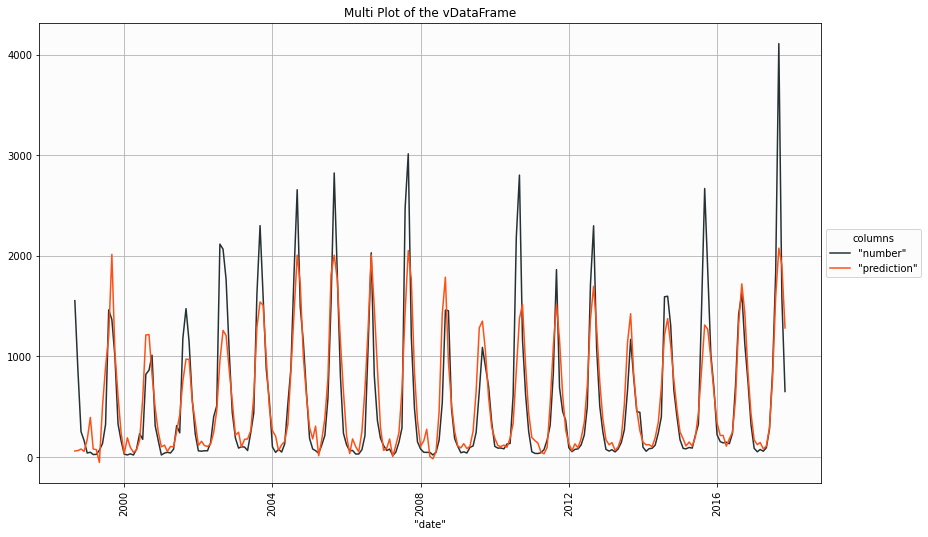

<object>  Name: groupby, Number of rows: 239, Number of columns: 3

In [14]:
amazon.plot(ts = "date", columns = ["number", "prediction"])

Fantastic: Our prediction seems to follow the trend ! 

## Conclusion

We have solved this use-case in a pandas-like way but we never loaded the data in memory. This example showed an overview of the library. You can now start your own project by looking at the documentation first.